In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [149]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d datascientistanna/customers-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat '/content/kaggle.json': No such file or directory
customers-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## Helping functions

In [150]:
from typing import List
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

class ModelData:
  def __init__(self, df):
    self.df_model = df

  def return_dataframe(self):
    return self.df_model

  def head(self):
    return self.df_model.head()

  def columns(self):
    return self.df_model.columns

  def unique(self, column):
    return self.df_model[column].unique()

  def bar(self, column):
    self.df_model[column].value_counts().sort_values().plot(kind = "barh")
  
  def info(self):
    return self.df_model.info()
  
  def describe(self):
    return self.df_model.describe()

  def null(self):
    return self.df_model.isnull().sum()

  def find_null_column(self) -> List:
    columns = self.df_model.columns[self.df_model.isnull().any()]
    return columns

  def dropnull(self):
    self.df_model.dropna(inplace=True)

  def rename(self, replace, replace_with):
    self.df_model = self.df_model.rename(columns={replace: replace_with})
  
  def drop(self, column):
    self.df_model = self.df_model.drop(column, axis=1)

  def fix_columns(self, columns:List[str] , method: str):
    if method == "mean":
      for column in columns:
        self.df_model[column].fillna(self.df_model[column].mean(), inplace=True)

  def fix_column_str(self, column):
    self.df_model[column] = self.df_model[column].replace('', "0")

  def fix_columns_values(self,column, threshold):
    for col, thr in zip(column, threshold):
      self.df_model[col] = self.df_model[col].apply(lambda x: self.df_model[col].mean() if x < thr else x)

  def count_column_condition(self, column1, column2, condition):
    '''
      Count specific value in another column (column2) when we group by column2 
      given condition that aplies to column2

      Inputs:
        -column1: Column to group by
        -column2: Column in which we trying to count elements
        -condition: given condition to column2

      Returns:
        - List of columns and count of elements for them
    '''
    return self.df_model.groupby(column1)[column2].apply(lambda x: (x == condition).sum())

  def delete_columns(self, columns: List[str]):
    for i in columns:
      self.df_model = self.df_model.drop(i, axis=1)

  def dtypes(self):
    return self.df_model.dtypes

  def corr(self):
    plt.figure(figsize=(16,16))
    sns.heatmap(data=self.df_model.corr(), annot=True, fmt=".2f")

  def normal_distribution(self, columns):
    for i in columns:
      col = self.df_model[i]
      mean, std_dev = norm.fit(col)
      plt.figure(figsize=(10,10))
      plt.hist(col, bins=20, density=True, alpha=0.6, color='g')
      xmin, xmax = plt.xlim()
      x = np.linspace(xmin, xmax, 100)
      p = norm.pdf(x, mean, std_dev)
      plt.plot(x, p, 'k', linewidth=2)
      title = f"Normal distribution of {i}: mean = {mean:.2f}, std dev = {std_dev:.2f}"
      plt.title(title)
      plt.show()


  def normal_distribution_label(self,label, columns):
    ones_label = self.df_model[self.df_model[label] == 1]
    zero_label = self.df_model[self.df_model[label] == 0]
    for i in columns:
      plt.figure(figsize=(10,10))
      ones_label[i].plot(kind="kde", color="green", title=i)
      zero_label[i].plot(kind="kde", color="red")
      plt.xlim([0,max(ones_label[i])])

  def dummies(self, columns):
    df = pd.get_dummies(self.df_model, columns = columns)
    self.df_model = df


  def min_max_scaler(self, columns):
    clf = MinMaxScaler()
    df_min_max = self.df_model[columns]
    data_transformed = clf.fit_transform(df_min_max.to_numpy())
    data_transformed = pd.DataFrame(data_transformed, columns=columns)
    df_one_hot = pd.concat([self.df_model.drop(columns, axis=1), data_transformed], axis=1)
    self.df_model = df_one_hot


In [151]:
from pandas.core.resample import SeriesGroupBy
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

class Regression():
  def __init__(self):
    self.sgd_regressor = SGDRegressor()
    self.lasso = linear_model.Lasso()
    self.elastic_net = ElasticNet()
    self.SVR = SVR()
    self.Ridge = Ridge()

  ## SGD
  def create_sgd(self,X,y):
    param_grid = {
        'loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error', 'huber'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'eta0': [0.001, 0.01, 0.1],
    }
    sgd = SGDRegressor()
    grid_search = GridSearchCV(sgd, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.sgd_regressor = best_model

  def score_sgd(self,X,y, method):
    preds = self.sgd_regressor.predict(X)
    if method == "mae":
      return mean_absolute_error(y, preds)
    if method == "mse":
      return mean_squared_error(y,preds)

  def evaluate_sgd(self, X):
    return self.sgd_regressor.predict(X)

  def get_sgd(self):
    return self.sgd_regressor

  #Lasso
  def create_lasso(self,X,y):
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'max_iter': [1000, 5000, 10000],
    }
    lasso = linear_model.Lasso()
    grid_search = GridSearchCV(lasso, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.lasso = best_model

  def score_lasso(self,X,y, method):
    preds = self.lasso.predict(X)
    if method == "mae":
      return mean_absolute_error(y, preds)
    if method == "mse":
      return mean_squared_error(y,preds)

  def evaluate_lasso(self, X):
    return self.lasso.predict(X)

  def get_lasso(self):
    return self.lasso

  ## ElasticNet
  def create_elastic_net(self,X,y):
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 5000, 10000],
    }
    elastic_net = ElasticNet()
    grid_search = GridSearchCV(elastic_net, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.elastic_net = best_model

  def score_elastic_net(self,X,y, method):
    preds = self.elastic_net.predict(X)
    if method == "mae":
      return mean_absolute_error(y, preds)
    if method == "mse":
      return mean_squared_error(y,preds)

  def evaluate_elastic_net(self, X):
    return self.elastic_net.predict(X)

  def get_elastic_net(self):
    return self.elastic_net

  ##Ridge
  def create_ridge(self,X,y):
    param_grid = {
        'alpha': [0.1, 1, 10],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
        'max_iter': [100, 500, 1000],
    }
    r = Ridge()
    grid_search = GridSearchCV(r, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.Ridge = best_model

  def score_ridge(self,X,y, method):
    preds = self.Ridge.predict(X)
    if method == "mae":
      return mean_absolute_error(y, preds)
    if method == "mse":
      return mean_squared_error(y,preds)

  def evaluate_ridge(self, X):
    return self.Ridge.predict(X)

  def get_ridge(self):
    return self.Ridge

  ##SVR
  def create_svr(self,X,y):
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
    }
    svc = SVR()
    grid_search = GridSearchCV(svc, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.SVR = best_model

  def score_svr(self,X,y, method):
    preds = self.SVR.predict(X)
    if method == "mae":
      return mean_absolute_error(y, preds)
    if method == "mse":
      return mean_squared_error(y,preds)

  def evaluate_svr(self, X):
    return self.SVR.predict(X)

  def get_svr(self):
    return self.SVR

  def mean_squared_error(self, y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

  def mean_absolute_error(self, y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

  def train_all_models(self, X,y):
    self.create_sgd(X,y)
    print("SGD_model created")
    self.create_lasso(X,y)
    print("Lasso created")
    self.create_elastic_net(X,y)
    print("ElasticNet created")
    self.create_svr(X,y)
    print("SVR created")
    self.create_ridge(X,y)
    print("Ridge created")

  def compare_model_all(self, X, y, method):
    df = pd.DataFrame(data={"SGDRegressor":self.score_sgd(X,y,method),
                            "Lasso": self.score_lasso(X,y,method),
                            "ElasticNet":self.score_elastic_net(X,y,method),
                            "SVR": self.score_svr(X,y, method),
                            "Ridge": self.score_ridge(X,y,method)},
                       index=["mae"])
    return df.transpose()

## Extracting data


In [152]:
zip_ref = zipfile.ZipFile("/content/customers-dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [153]:
df = pd.read_csv("Customers.csv")
df = ModelData(df)

In [154]:
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [155]:
df.dtypes()

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income ($)          int64
Spending Score (1-100)     int64
Profession                object
Work Experience            int64
Family Size                int64
dtype: object

In [156]:
df.null()

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


In [158]:
df.dropnull()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              1965 non-null   int64 
 1   Gender                  1965 non-null   object
 2   Age                     1965 non-null   int64 
 3   Annual Income ($)       1965 non-null   int64 
 4   Spending Score (1-100)  1965 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         1965 non-null   int64 
 7   Family Size             1965 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 138.2+ KB


In [159]:
df.null()

CustomerID                0
Gender                    0
Age                       0
Annual Income ($)         0
Spending Score (1-100)    0
Profession                0
Work Experience           0
Family Size               0
dtype: int64

In [160]:
df.dtypes()

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income ($)          int64
Spending Score (1-100)     int64
Profession                object
Work Experience            int64
Family Size                int64
dtype: object

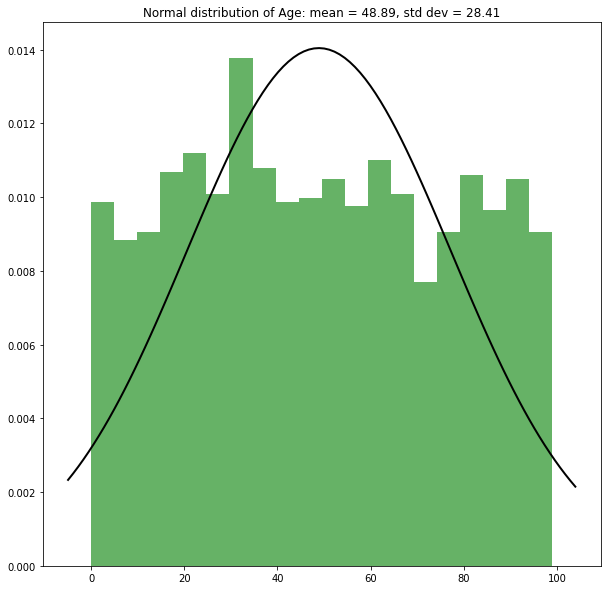

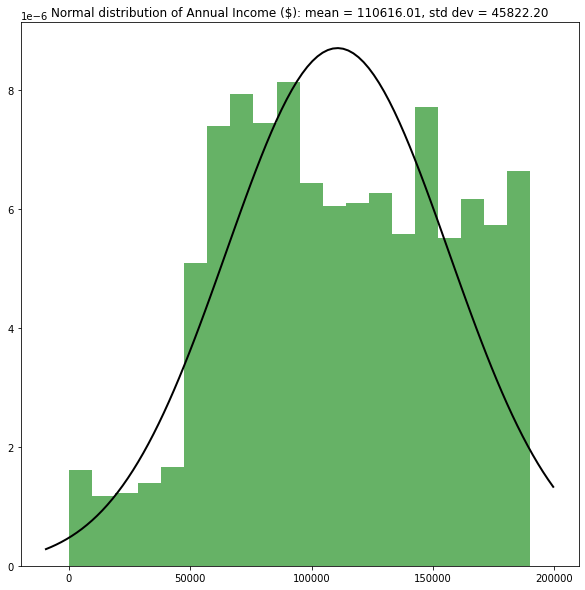

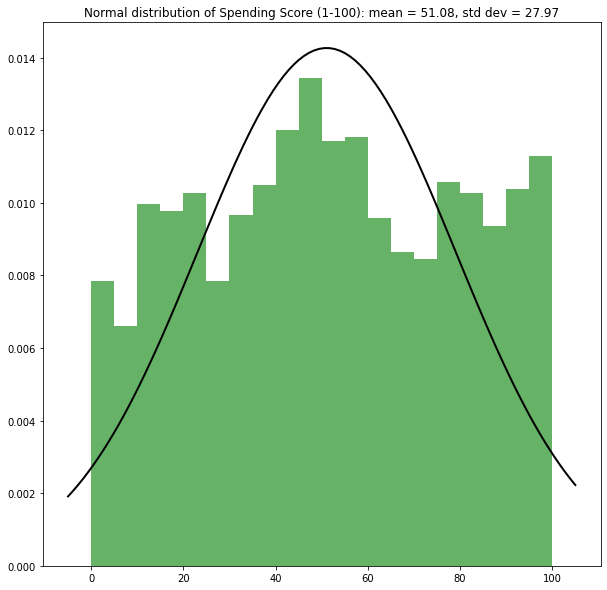

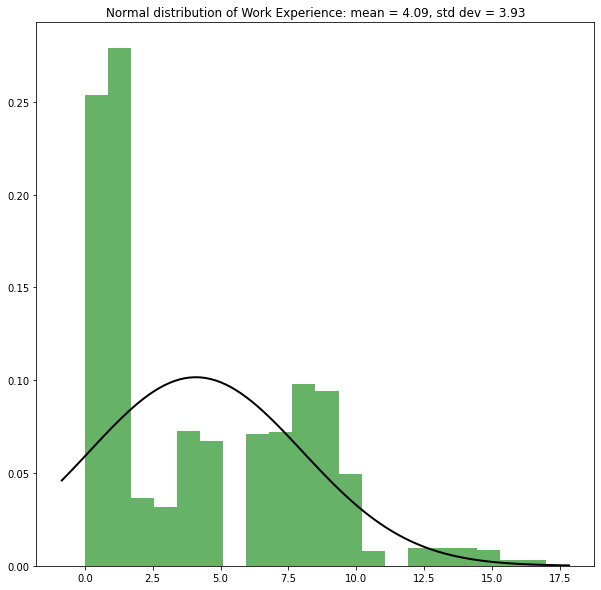

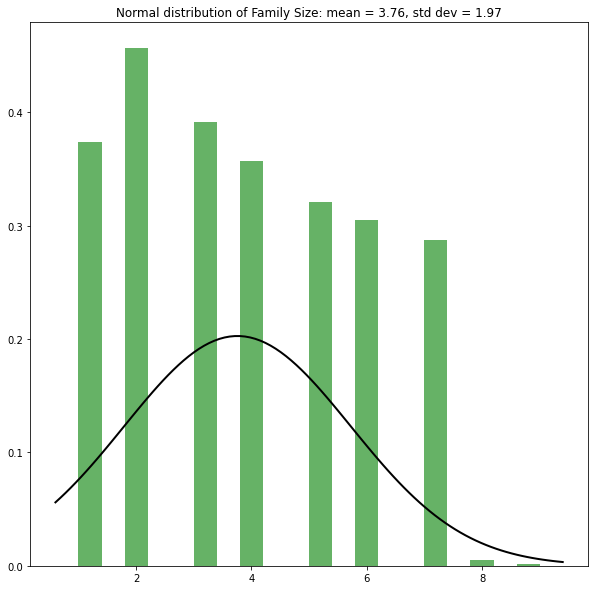

In [161]:
df.normal_distribution(["Age", "Annual Income ($)", "Spending Score (1-100)", "Work Experience", "Family Size"])

In [162]:
df.unique("Profession")

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing'], dtype=object)

In [163]:
df.columns()

Index(['CustomerID', 'Gender', 'Age', 'Annual Income ($)',
       'Spending Score (1-100)', 'Profession', 'Work Experience',
       'Family Size'],
      dtype='object')

## Prepare data

In [164]:
def preparing_data(df):
  df = ModelData(df)
  df.dropnull()
  df.drop("CustomerID")
  df.rename("Annual Income ($)", "Income")
  df.rename("Work Experience", "Work_Experience")
  df.rename("Family Size", "Family_Size")
  df.rename("Spending Score (1-100)", "Spending")

  df.drop("Age")
  df.min_max_scaler(["Income","Work_Experience", "Family_Size"])
  df.dummies(["Profession", "Gender"])
  df.dropnull()
  df_train = df.return_dataframe()  
  return df_train

In [165]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("/content/Customers.csv")
df_processed = preparing_data(df)
X = df_processed.drop("Spending", axis=1)
y = df_processed["Spending"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train data

In [166]:
models = Regression()
models.train_all_models(X_train,y_train)

SGD_model created
Lasso created
ElasticNet created
SVR created
Ridge created


## Compare models

In [167]:
models.compare_model_all(X_test, y_test, method="mse")

,mae
SGDRegressor,742.338931
Lasso,741.940965
ElasticNet,741.940965
SVR,747.810261
Ridge,744.058235


In [168]:
preds = models.evaluate_ridge(X_test)
df_data = pd.DataFrame(data={"y_true": y_test, "y_pred": preds})
df_data

,y_true,y_pred
1139,90.0,51.210981
1685,20.0,54.714042
1898,95.0,49.509533
958,48.0,50.539237
335,30.0,50.258143
...,...,...
575,34.0,54.474991
732,86.0,52.405852
1153,55.0,50.406308
996,36.0,53.115672


## Deep Learning

In [169]:
import tensorflow as tf

In [170]:
df = pd.read_csv("/content/Customers.csv")
df_processed = preparing_data(df)
X = df_processed.drop("Spending", axis=1)
y = df_processed["Spending"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1)     
])

model.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam(),metrics=['mae'])
model.fit(X_train,y_train,epochs=100, verbose=0)


In [172]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 23.8246 - mae: 23.8246


[23.82461929321289, 23.82461929321289]

In [173]:
preds = model.predict(X_test)
df_data = pd.DataFrame(data={"y_true": y_test, "y_pred": tf.squeeze(preds)})
df_data

13/13 [==============================] - 0s 1ms/step


,y_true,y_pred
1139,90.0,52.159714
1685,20.0,58.743755
1898,95.0,45.117558
958,48.0,44.255299
335,30.0,54.821426
...,...,...
575,34.0,59.688469
732,86.0,49.875282
1153,55.0,59.526726
996,36.0,48.654972


## Trying to better prepare data


In [174]:
df = pd.read_csv("/content/Customers.csv")
df = ModelData(df)
df.columns()

Index(['CustomerID', 'Gender', 'Age', 'Annual Income ($)',
       'Spending Score (1-100)', 'Profession', 'Work Experience',
       'Family Size'],
      dtype='object')

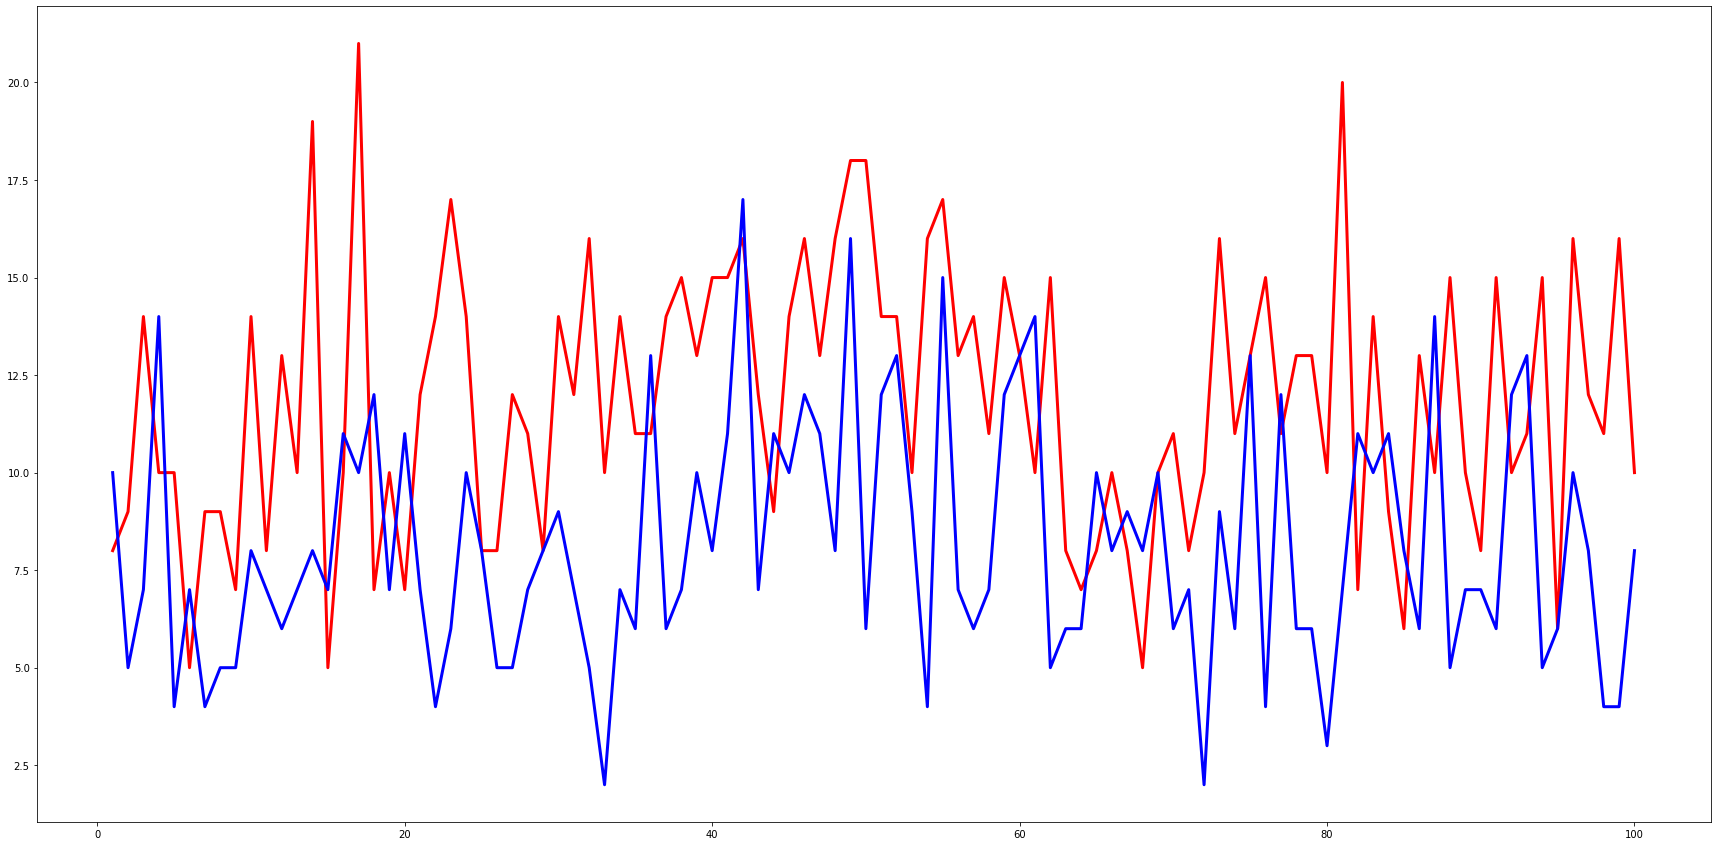

In [175]:
arr = []

for i in range(1,101):
  f,m =  df.count_column_condition("Gender", "Spending Score (1-100)", i)
  arr.append([f,m])

arr = np.array(arr)
i = np.linspace(1,100,100)
plt.figure(figsize=(30,15))
plt.plot(i, arr[:,0], color='red',linewidth='3')
plt.plot(i, arr[:,1], color='blue',linewidth='3')

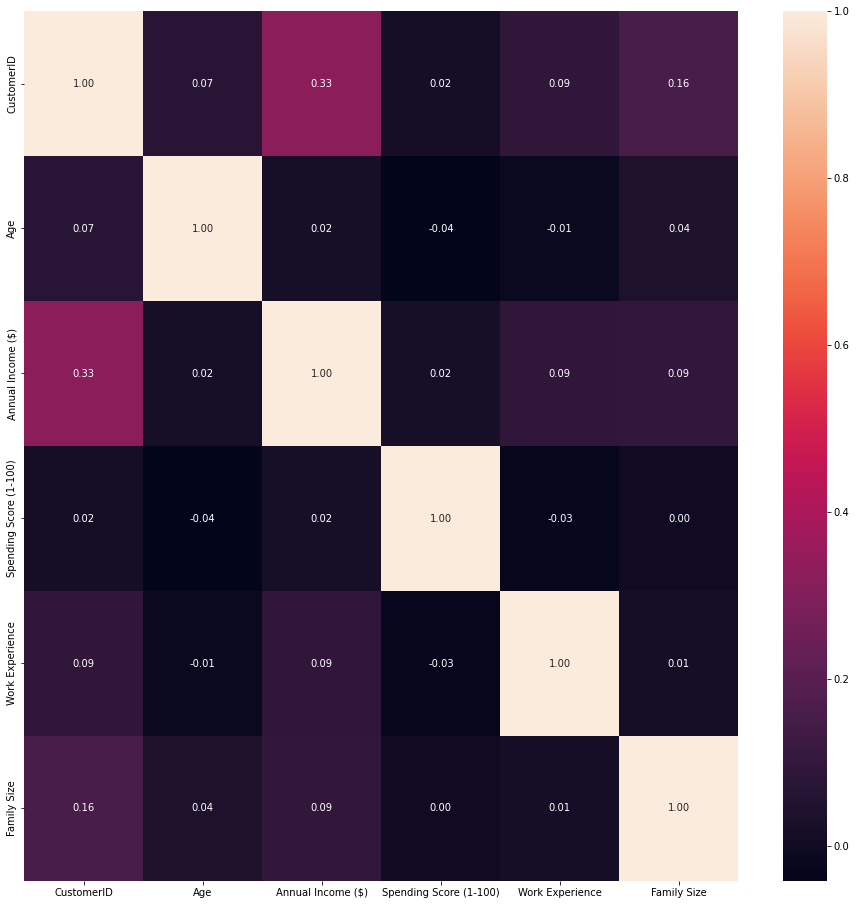

In [176]:
df.corr()

- Classify the age by groups children (0-13), teen (14-18), adult(19-60), senior(61-)

- Work experience by groups noexp(0), low(1-3), medium(4-10), high(>11)


In [180]:
def preparing_data(df):
  df = ModelData(df)
  df.dropnull()
  df.drop("CustomerID")
  df.rename("Annual Income ($)", "Income")
  df.rename("Work Experience", "Work_Experience")
  df.rename("Family Size", "Family_Size")
  df.rename("Spending Score (1-100)", "Spending")
  df_help = df.return_dataframe()
  df_help["Age"] = df_help['Age'].apply(lambda x: 'childerm' if x < 13 else ("teen" if x < 19 else ("adult" if x < 61 else "seniors")))
  df_help["Work_Experience"] = df_help['Work_Experience'].apply(lambda x: 'noexp' if x== 0 else ("low" if x < 3 else ("medium" if x < 11 else "high")))

  df = ModelData(df_help)
  df.min_max_scaler(["Income", "Family_Size"])
  df.dummies(["Profession", "Gender", "Age", "Work_Experience"])
  df.dropnull()
  df_train = df.return_dataframe()  
  return df_train

In [181]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("/content/Customers.csv")
df_processed = preparing_data(df)
X = df_processed.drop("Spending", axis=1)
y = df_processed["Spending"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
models = Regression()
models.train_all_models(X_train,y_train)

SGD_model created
Lasso created
ElasticNet created
SVR created
Ridge created


In [183]:
models.compare_model_all(X_test, y_test, method="mse")

,mae
SGDRegressor,742.335561
Lasso,741.940965
ElasticNet,741.940965
SVR,742.613758
Ridge,740.996557


In [184]:
preds = models.evaluate_ridge(X_test)
df_data = pd.DataFrame(data={"y_true": y_test, "y_pred": preds})
df_data

,y_true,y_pred
1139,90.0,51.677010
1685,20.0,54.275496
1898,95.0,48.837089
958,48.0,50.181106
335,30.0,49.719618
...,...,...
575,34.0,53.905607
732,86.0,55.534599
1153,55.0,49.663829
996,36.0,54.242004


In [185]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1)     
])

model.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam(),metrics=['mae'])
model.fit(X_train,y_train,epochs=100, verbose=0)

In [186]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 24.1160 - mae: 24.1160


[24.115999221801758, 24.115999221801758]

In [187]:
preds = model.predict(X_test)
df_data = pd.DataFrame(data={"y_true": y_test, "y_pred": tf.squeeze(preds)})
df_data

13/13 [==============================] - 0s 1ms/step


,y_true,y_pred
1139,90.0,40.562901
1685,20.0,53.136047
1898,95.0,41.186592
958,48.0,48.461945
335,30.0,50.612946
...,...,...
575,34.0,67.044487
732,86.0,32.931938
1153,55.0,60.794437
996,36.0,50.881992
